In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)

css_styling()

In [2]:
from torch import max, no_grad
from torch.nn import Conv2d, MaxPool2d, ReLU, Softmax, Flatten, Module, Linear, CrossEntropyLoss
from torch.nn import functional as f
from torch.optim import Adam, SGD
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.datasets import MNIST

Setting the mean and std dev to 0.5 and 0.5 repectively.

Since are intensity values are 0 and 1, 

 - Min value: (0 - 0.5)/0.5 = -1

 - Max value: (1 - 0.5)/0.5 = 1

In [3]:
transform = Compose([
    ToTensor(),
    Normalize((0.5, ), (0.5, )),
])

In [4]:
train = MNIST(
    "mnist",
    train=True,
    download=True,
    transform=transform,
)

test = MNIST(
    "mnist",
    train=False,
    download=True,
    transform=transform,
)

In [5]:
print(train.data.shape)
print(test.data.shape)
print(train.data[0].shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([28, 28])


In [6]:
from torch.utils.data import DataLoader

In [7]:
trainloader = DataLoader(
    train,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)
testloader = DataLoader(
    test,
    batch_size=32,
    shuffle=False,
    num_workers=0,
)

### Building the model

In [8]:
 class ConvNet(Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.fc_1 = Linear(64 * 12 * 12, 128)
        self.fc_2 = Linear(128, 10)
        
    def forward(self, x):
        x = f.relu(self.conv_1(x))
        x = self.maxpool(f.relu(self.conv_2(x)))
        x = x.view(-1, 64*12*12)  # Flatten Layer
        x = f.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [9]:
covnet = ConvNet()

In [10]:
covnet.to("cpu")

ConvNet(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(covnet.parameters(), lr=0.001, momentum=0.9)

### Training the model

In [19]:
epochs = 5

epoch_log = []
loss_log = []
acc_log = []

for epoch in range(epochs):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        
        optimizer.zero_grad()
        outputs = covnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()  # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights
        
        running_loss += loss.item()
        
        if i % 50 == 49:
            correct = 0
            total = 0
            
            with no_grad():
                for data in testloader:
                    images, labels = data
                    images = images.to("cpu")
                    labels = labels.to("cpu")
                    
                    outputs = covnet(images)
                    
                    _, predicted = max(outputs.data, dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                
                acc = 100 * correct / total
                actual_loss = running_loss / 50.0
                print(f"Epoch: {(epoch+1)}, Minibatches completed: {(i+1)}, Loss: {actual_loss:.3f}, Test acc: {acc:.3f}")
                
                running_loss = 0.0
            
    epoch_log.append((epoch+1))
    loss_log.append(actual_loss)
    acc_log.append(acc)

Epoch: 1, Minibatches completed: 50, Loss: 2.272, Test acc: 22.040
Epoch: 1, Minibatches completed: 100, Loss: 2.151, Test acc: 58.600
Epoch: 1, Minibatches completed: 150, Loss: 1.814, Test acc: 73.100
Epoch: 1, Minibatches completed: 200, Loss: 1.115, Test acc: 80.340
Epoch: 1, Minibatches completed: 250, Loss: 0.702, Test acc: 83.490
Epoch: 1, Minibatches completed: 300, Loss: 0.527, Test acc: 84.100
Epoch: 1, Minibatches completed: 350, Loss: 0.497, Test acc: 86.510
Epoch: 1, Minibatches completed: 400, Loss: 0.438, Test acc: 88.820
Epoch: 1, Minibatches completed: 450, Loss: 0.381, Test acc: 88.540
Epoch: 1, Minibatches completed: 500, Loss: 0.402, Test acc: 89.270
Epoch: 1, Minibatches completed: 550, Loss: 0.386, Test acc: 90.210
Epoch: 1, Minibatches completed: 600, Loss: 0.389, Test acc: 90.310
Epoch: 1, Minibatches completed: 650, Loss: 0.382, Test acc: 90.200
Epoch: 1, Minibatches completed: 700, Loss: 0.387, Test acc: 89.360
Epoch: 1, Minibatches completed: 750, Loss: 0.319

Epoch: 4, Minibatches completed: 500, Loss: 0.044, Test acc: 97.990
Epoch: 4, Minibatches completed: 550, Loss: 0.075, Test acc: 98.270
Epoch: 4, Minibatches completed: 600, Loss: 0.073, Test acc: 98.050
Epoch: 4, Minibatches completed: 650, Loss: 0.071, Test acc: 98.100
Epoch: 4, Minibatches completed: 700, Loss: 0.050, Test acc: 97.870
Epoch: 4, Minibatches completed: 750, Loss: 0.058, Test acc: 98.170
Epoch: 4, Minibatches completed: 800, Loss: 0.051, Test acc: 98.110
Epoch: 4, Minibatches completed: 850, Loss: 0.061, Test acc: 97.980
Epoch: 4, Minibatches completed: 900, Loss: 0.060, Test acc: 98.260
Epoch: 4, Minibatches completed: 950, Loss: 0.063, Test acc: 98.080
Epoch: 4, Minibatches completed: 1000, Loss: 0.053, Test acc: 98.240
Epoch: 4, Minibatches completed: 1050, Loss: 0.050, Test acc: 97.940
Epoch: 4, Minibatches completed: 1100, Loss: 0.081, Test acc: 98.200
Epoch: 4, Minibatches completed: 1150, Loss: 0.059, Test acc: 98.220
Epoch: 4, Minibatches completed: 1200, Loss:

### Saving the model

In [20]:
from torch import save, load
PATH = "./mnist_cnn_path.pth"

In [21]:
save(covnet.state_dict(), PATH)

### Loading model

In [22]:
net = ConvNet()
net.to("cpu")
net.load_state_dict(load(PATH))

<All keys matched successfully>

### Test accuracy

In [23]:
correct = 0
total = 0

with no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cpu")
        labels = labels.to("cpu")
        
        outputs = net(images)
        _, pred = max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        
test_acc = 100 * correct / total
test_acc

98.67

### Plotting results

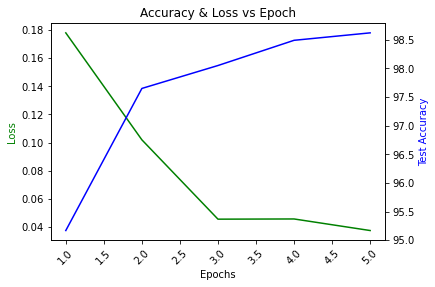

In [24]:
# To create a plot with secondary y-axis we need to create a subplot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, acc_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

### Getting confusion matrix

In [25]:
from sklearn.metrics import confusion_matrixusion_matrix, classification_report

In [32]:
from torch import zeros, long, cat

In [34]:
pred_list = zeros(0, dtype=long, device="cpu")
label_list = zeros(0, dtype=long, device="cpu")

with no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        
        outputs = net(inputs)
        _, preds = max(outputs.data, 1)
        
        pred_list = cat([pred_list, preds.view(-1).cpu()])
        label_list = cat([label_list, labels.view(-1).cpu()])

In [35]:
cm = confusion_matrix(label_list.numpy(), pred_list.numpy())
print(cm)

[[ 970    0    1    0    0    1    3    1    3    1]
 [   0 1124    3    0    0    2    3    1    2    0]
 [   2    1 1023    0    1    0    0    3    2    0]
 [   0    0    1 1002    0    4    0    2    1    0]
 [   0    0    1    0  974    0    3    0    0    4]
 [   2    0    1    4    0  881    1    1    0    2]
 [   4    2    0    0    2    4  945    0    1    0]
 [   1    0   11    1    0    0    0 1013    0    2]
 [   5    0    6    1    2    0    1    3  953    3]
 [   2    1    0    3    7    1    2    9    2  982]]
